# Blobs and SIFT features

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

from lib import gaussianSmoothing, gaussian1DKernels

## Blob detector
We will use the Difference of Gaussian (DoG) method to detect blobs.

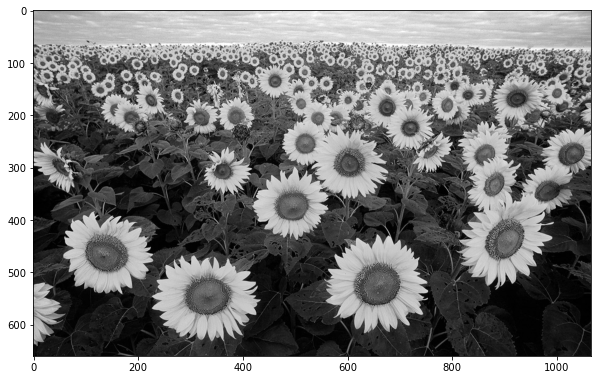

In [2]:
color_im = cv2.imread("data/sunflowers.jpg")[:, :, [2, 1, 0]]
im = cv2.imread("data/sunflowers.jpg", 0) / 255
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im, cmap="gray");

### 1. Scale pyramid of the image

In [3]:
def scaleSpaced(im, sigma, n):
    """
    Apply a Gaussian kernel of width sigma*2**i, i = 0, 1, ..., n − 1

    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid

    Return
    ------
    im_scales: n * I.shape array
        scale pyramid of the original image.
    """
    im, _, _ = gaussianSmoothing(im=im, sigma=sigma)
    im_scales = [im.copy()]
    for i in range(n):
        im, _, _ = gaussianSmoothing(im=im, sigma=sigma)
        im_scales.append(im.copy())
        sigma *= 2
    return np.array(im_scales)

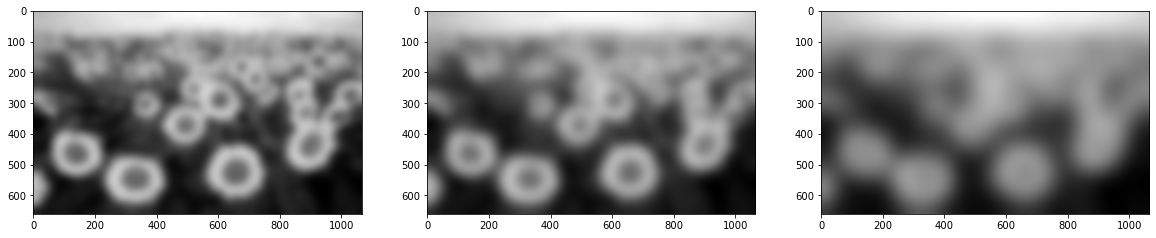

In [5]:
n=3
sigma=15

im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
fig, ax=plt.subplots(1, n, figsize=(20, 5))
for i in range(n):
    ax[i].imshow(im_scales[i], cmap="gray")

### 2. Difference of Gaussians

$k=2^{\frac{1}{3}}$

In [6]:
def differenceOfGaussian(im, sigma, n):
    """
    Return the scale space DoG of the image
    
    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid
    Return
    ------
    DoG: (n - 1) * I.shape array
        scale space DoGs of the original image.
    """
    im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
    DoGs = [im_scales[i + 1] - im_scales[i] for i in range(n - 1)]
    return np.array(DoGs)

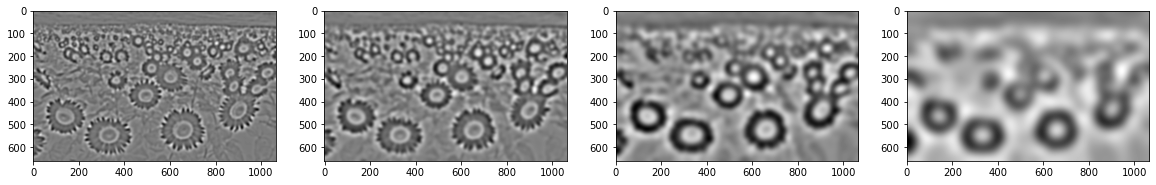

In [7]:
n=5
sigma=5

DoGs = differenceOfGaussian(im=im, sigma=sigma, n=n)
fig, ax=plt.subplots(1, n - 1, figsize=(20, 5))
for i in range(n - 1):
    ax[i].imshow(DoGs[i], cmap="gray")

### 3. BLOBs

In [65]:
def detectBlobs(im, sigma, n, threshold, order=1):
    """
    Return blobs in the image.
    
    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid

    Return
    ------
    blobs:
        blobs (pixels) of the original image with a DoG larger than the
        threshold.
    """
    DoGs = np.abs(differenceOfGaussian(im=im, sigma=sigma, n=n))
    blobs = non_maximum_suppression(DoGs, order) > threshold
    return np.array(blobs)


def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    Parameters
    ---------
    data : 3d ndarray
    order : int
        How many points on each side to use for the comparison

    Returns
    -------
    coords : ndarray
        coordinates of the local maxima
    values : ndarray
        values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((3, size, size))
    footprint[1, order, order] = 0
    filtered = scipy.ndimage.maximum_filter(data, footprint=footprint)
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

In [66]:
sigma = 5
n = 7

blobs = detectBlobs(im, sigma, n, threshold=0.12, order=10)
centers = np.argwhere(blobs)[:, 1:]

DoGs = differenceOfGaussian(im=im, sigma=sigma, n=n)
radius= (2 ** np.argwhere(blobs)[:, 0] * sigma).astype(int)

In [67]:
np.min(np.argwhere(blobs)[:, 0]), np.max(np.argwhere(blobs)[:, 0])

(1, 4)

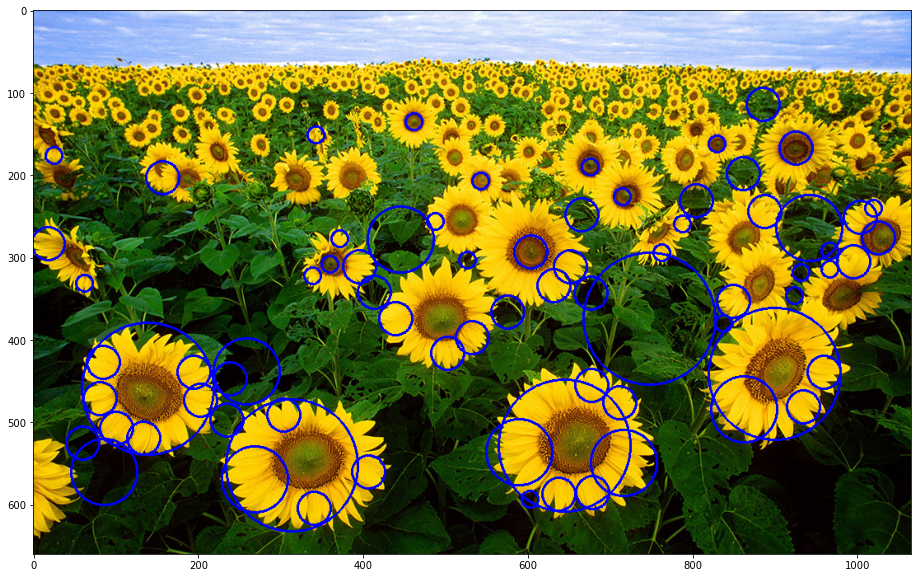

In [68]:
im_copy = color_im.copy()
for i in range(np.sum(blobs)):
    cv2.circle(img=im_copy, center=centers[i, [-1, 0]], radius=radius[i], color=(0, 0, 255), thickness=2)
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(im_copy);

## SIFT

### 4. Image transformation

In [ ]:
def transformIm(im, theta, s):
    """Return a scaled and rotated version of the original image im."""
    